# Instructions of this exercise

This jupyter notebook is an exercise for you to understand the basics of LSTM language models.

The different sections have comments that will guide you through the different stages of the processing.

**You will find parts in this notebook that are missing. They are marked with a <font color="red">"TODO"</font>, with an explanation about what you are supposed to write/code in that gap. Sometimes you may be requested to implement an algorithm or a piece of code that behaves in a specific way. Other times, you may be requested to explain what a specific piece of code does or why it is needed.** In some cases, the requests may contain a "trap", e.g. the thing you are requested to implement can't be done for whatever reason, or it may need an extra preprocessing step for it to be possible.

If you have any doubt, do not hesitate to contact the instructor at noe.casas@upc.edu

---



# Requirements

In order to follow this notebook you need working knowledge on:

* Python programming.
* Pytorch basics.
* Language modeling basics.
* Unix command line basics (cat, head, tail, awk).

If you lack any of them, please acquire the needed knowledge on the internet, where there is plenty of material about the three topics.

---

# Introduction

Language Modeling is the task of predicting each token based on the previous ones. Formally, a language models the probability distribution of the token at position $t$, which is referred to as $y_t$, conditioning it on the previous tokens $y_1,\ldots,y_{t-1}$, that is, an LM models $p\left(y_t|  y_1, \ldots, y_{t-1} \right)$

A classical approach for LMs is to use a recurrent unit, either an LSTM or a GRU. In this exercise you will be implementing an LSTM LM.

---
## Installation of extra libraries

The extra libraries we will use are:
* **sacremoses**: the is a classical translation tool called "Moses" (https://github.com/moses-smt/mosesdecoder). Apart from translation tools, it offers a lot of different preprocessing scripts (written in the Perl programming language). These scripts are ubiquitous in the NLP world. Instead of using Moses scripts, we will use sacremoses, which is a reimplementation of the most useful Moses scripts in Python.

In [1]:
!pip install torch
!pip install numpy
!pip install -U https://github.com/alvations/sacremoses/archive/master.zip

  Using cached https://github.com/alvations/sacremoses/archive/master.zip
  Created wheel for sacremoses: filename=sacremoses-0.0.40-cp36-none-any.whl size=884544 sha256=20f5c0362633315699b7a4503ce93b9976fe77b7020a6bf2b7e0c926a06cd82b
  Stored in directory: /tmp/pip-ephem-wheel-cache-3v9i1d54/wheels/a9/8b/db/e688b9d5eecd3518dd27712980c76599bcd8312ee220f4878e
Successfully built sacremoses
  Found existing installation: sacremoses 0.0.40
    Uninstalling sacremoses-0.0.40:
      Successfully uninstalled sacremoses-0.0.40


---

## General Imports

Now we will import some components that will be used throughout the notebook

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

---

## Reproducibility

We fix the random seed for reproducibility purposes. See this for details:
https://pytorch.org/docs/stable/notes/randomness.html

In [0]:
seed = 321
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

---

## Data Download

For this notebook we will use a dataset widely used in machine translation, called "News Commentary". We will be using some English subsets of News Commentary as training, validation and test data.

First, we will download the dataset from the internet and extract some parts into files `train.en`, `valid.en` and `test.en`:

In [0]:
!wget --quiet 'http://data.statmt.org/wmt17/translation-task/training-parallel-nc-v12.tgz'
!tar xzf training-parallel-nc-v12.tgz
!mv training/news-commentary-v12.fr-en.en ./train.en
!bash -c "shuf --random-source=<(openssl enc -aes-256-ctr -pass pass:42 -nosalt </dev/zero 2>/dev/null)" < training/news-commentary-v12.zh-en.en > shuffled.en
!head -5000 < shuffled.en > valid.en
!tail -5000 < shuffled.en > test.en

News commentary is text from news, where each line of the file is a separate sentence. Let's take a look at the number of sentences in each file:

In [5]:
!wc -l train.en valid.en test.en

  258432 train.en
    5000 valid.en
    5000 test.en
  268432 total


---


## Data preprocessing

In general, it is of utmost importance to understand the data you are working with, so let's have a look at the text:

In [6]:
!head -5 train.en

$10,000 Gold?
SAN FRANCISCO – It has never been easy to have a rational conversation about the value of gold.
Lately, with gold prices up more than 300% over the last decade, it is harder than ever.
Just last December, fellow economists Martin Feldstein and Nouriel Roubini each penned op-eds bravely questioning bullish market sentiment, sensibly pointing out gold’s risks.
Wouldn’t you know it?


As a first preprocessing step, we will:
* **normalize punctuation**: convert punctuation marks so that only the most standard ones are used. For instance, unicode curly quotes (“”) will be converted to straigh ones (").
* **tokenize**: words and punctuation will be separated with spaces, and contractions may be expanded. For instance, sentence "No, he wasn't there." will be converted to "No , he was n't there ."
* **lowercase**: turn all alphabetical characters into lowercase, so that the embeddings we obtain are independent from the original casing.

In [7]:
!cat train.en | sacremoses normalize -l en | sacremoses tokenize -l en | awk '{ print tolower($0) }' > train.low.tok.en
!cat valid.en | sacremoses normalize -l en | sacremoses tokenize -l en | awk '{ print tolower($0) }' > valid.low.tok.en
!cat test.en  | sacremoses normalize -l en | sacremoses tokenize -l en | awk '{ print tolower($0) }' > test.low.tok.en

100% 258961/258961 [00:40<00:00, 6419.02it/s]
100% 258961/258961 [00:52<00:00, 4913.84it/s]
100% 5000/5000 [00:00<00:00, 6477.65it/s]
100% 5000/5000 [00:01<00:00, 4357.24it/s]
100% 5004/5004 [00:00<00:00, 6231.89it/s]
100% 5004/5004 [00:01<00:00, 4525.64it/s]


Let's look how our data looks like after the described preprocessing steps:

In [8]:
!head -10 train.low.tok.en

$ 10,000 gold ?
san francisco - it has never been easy to have a rational conversation about the value of gold .
lately , with gold prices up more than 300 % over the last decade , it is harder than ever .
just last december , fellow economists martin feldstein and nouriel roubini each penned op-eds bravely questioning bullish market sentiment , sensibly pointing out gold &apos;s risks .
wouldn &apos;t you know it ?
since their articles appeared , the price of gold has moved up still further . gold prices even hit a record-high $ 1,300 recently .
last december , many gold bugs were arguing that the price was inevitably headed for $ 2,000 .
now , emboldened by continuing appreciation , some are suggesting that gold could be headed even higher than that .
one successful gold investor recently explained to me that stock prices languished for a more than a decade before the dow jones index crossed the 1,000 mark in the early 1980 &apos;s .
since then , the index has climbed above 10,000 .


Now we have our 3 final files: `train.low.tok.en`, `valid.low.tok.en` and `test.low.tok.en`.

Note that, at each preprocessing step, we have been creating new files with extra suffixes indicating the type of preprocessing.

---

## Text Loading

We will load the text from our 3 files into python variables. The text in a file will be represented as a list of sentences, where each sentence is a list of words (strings).

In [0]:
def load_text_tokens(filename):
    """
    Loads the text in the filename as a list of list of words.
    :param filename Name of the file to load in memory.
    :return List of list of strings with the contents of the file.
    """
    text = []
    with open(filename) as f:
        for line in f:
            line = line.strip() # remove leading and training blanks

            # split words at blanks (the text is already tokeniked)
            line_tokens = line.split(' ')

            if len(line_tokens) < 5:
              continue  # ignore too short lines

            text.append(line_tokens)
    return text

In [0]:
train_tokens = load_text_tokens('train.low.tok.en')
valid_tokens = load_text_tokens('valid.low.tok.en')
test_tokens = load_text_tokens('test.low.tok.en')

## Vocabulary Extraction

Given the huge amount of possible word in a language, when creating word embeddings, we need to constrain the set of supported words. This way, we will be having a list of words for which we will compute embeddings. This list is known as the **vocabulary**. The vocabulary is created by selecting the most frequent words in the training data.

As the vocabulary is finite, there are some words it won't be able to represent. We will use a **special token** to represent these "out of vocabulary" words, normally referred to as the **&lt;UNK&gt;** token.

We will also use another special token **&lt;EOS&gt;** to represent the ending of a sentente (EOS stands for end of sequence).

In [0]:
def extract_vocabulary(text_tokens, vocab_size):
    from collections import Counter
    unk_token = '<UNK>'
    eos_token = '<EOS>'
    special_tokens = [unk_token, eos_token]
    counter = Counter(word for sentence in text_tokens for word in sentence)
    most_common_counts = counter.most_common(vocab_size - len(special_tokens))
    most_frequent_words = [word for (word, count) in most_common_counts]
    idx2token = special_tokens + most_frequent_words
    token2idx = {token: token_id for token_id, token in enumerate(idx2token)}
    return unk_token, eos_token, idx2token, token2idx

In [0]:
VOCAB_SIZE=30000
unk_token, eos_token, idx2token, token2idx = extract_vocabulary(train_tokens, vocab_size=VOCAB_SIZE)
unk_token_id = token2idx[unk_token]
eos_token_id = token2idx[eos_token]

## Text Encoding

To feed words to our neural network, we need to express them as numbers. This way, a word will be represented as the index it occupies in the vocabulary table. With this in mind, let's encoder the training, validation and test datasets:


In [0]:

def encode_token_ids(text_tokens, vocabulary, unk_token_id, eos_token):
    """
    Create a list with all the token IDs in the data. Note that all sentences
    are concatenated one after the other.
    :param text_tokens 
    """
    return [vocabulary.get(token, unk_token_id)
            for sentence in text_tokens for token in sentence + [eos_token]]

In [0]:
train_token_ids = torch.LongTensor(encode_token_ids(train_tokens, token2idx, unk_token_id, eos_token))
valid_token_ids = torch.LongTensor(encode_token_ids(test_tokens, token2idx, unk_token_id, eos_token))
test_token_ids = torch.LongTensor(encode_token_ids(test_tokens, token2idx, unk_token_id, eos_token))

## Batch Preparation

The way textual data is fed to a Language Model is not very self-evident (at least to me).

First, some <u>background</u>:

**How are images fed to image-processing neural networks?** Normally, we assume that the size of the images that will be used as input to a neural networl is constant, that is, all images are assumed to be the same size. This allows use to create mini-batches easily: if we have $n$ color images of size $w \times h$, each image is represented by a tensor of shape [3, w, h] (the "3" is because a color image is normally represented with 3 channels: red, green and blue), so we just stack the $n$ images together into a tensor of shape `[n, 3, w, h]`. Therefore, because we have input data of the same size, creating batches is easy.

**How are text sentences fed to neural machine translation (NMT) or text classification networks?** In these cases, each piece of input data is a sequence of tokens, where each token is an integer number, normally the index of the token in the vocabulary table. Each sentence can have a differnt length. In order to compose a mini-batch, we make all sentences in the batch artificially longer, to match the length of the longest sentence. In order to do that, we will each sentence to the right with a special "padding token". For instance, if we want to pad a sentence of length 5 to fit in a batch where the maximum sequence length is 8, we need to add 3 padding tokens to the right of the last token in the sentence.

Now, **how are text sentences fed to language models?** It would be possible to do the same as with NMT/text classification networks, but that's not the usual way to do it. Why? Because that way we would not be using the context from the previous sentences to make the next token predictions. In order to be able to profit from previous sentences' information, we do as follows: we concatenate all sentences together in a single long super sequence (the boundary between sentences is normally marked with an &lt;EOS&gt; token) and then, we create the batches so that they include $n$ fragments of fixed-length text so that they are "connected" to the $n$ fragments from the previous batch that we gave to the network. This means that the piece of fixed-length text at position $k$ in a batch is the continuation of the sentence at position $k$ in the previous batch. To actually be able to use the context from the previous batch in the predictions of the current batch, the last hidden states of the previous batch are used as initial hidden states for the current batch. The propagation of the gradients between different batches is severed, though. This is called "**truncated back-propagation through time**" (T-BPTT). The following functions are in charge of preparing the mini-batches in the appropriate way:

In [0]:
def prepare_data(data, batch_size):
    """
    Starting from sequential data, this function arranges the dataset into columns.
    For instance, with the alphabet as the sequence and batch size 4, we'd get
    ┌ a g m s ┐
    │ b h n t │
    │ c i o u │
    │ d j p v │
    │ e k q w │
    └ f l r x ┘.
    These columns are treated as independent by the model, which means that the
    dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
    batch processing.
    :param data LongTensor with a vector with all the data to prepare.
    :
    """
    # Compute how we can divide the dataset into batch_size parts.
    nbatch = data.size(0) // batch_size
    
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * batch_size)

    # Evenly divide the data across the batch_size batches.
    data = data.view(batch_size, -1).t().contiguous()

    return data.cuda()

In [0]:
def get_batch_k(source, bptt, k):
    """
    Subdivides the source data into chunks of length bptt (backprop through time).
    If source is equal to the example output of the prepare_data function, with
    a bptt-limit of 3, we'd get the following two Tensors for k = 0:
    ┌ a g m s ┐ ┌ b h n t ┐
    | b h n t | | c i o u |
    └ c i o u ┘ └ d j p v ┘
    Note that the subdivison of data is not done along the batch dimension
    (i.e. dimension 1), since that was handled by the prepare_data function.
    The chunks are along dimension 0, corresponding to the seq_len dimension in
    the LSTM.
    """
    seq_len = min(bptt, len(source) - 1 - k)
    input_start = k
    input_end   = k + seq_len
    input = source[input_start:input_end]
    target = source[input_start + 1:input_end + 1].view(-1)
    return input, target

# Training boilerplate

Now we will define some functions to train and evaluate a language model:

In [0]:
def train_epoch(model, criterion, optimizer, vocab_size, train_data, batch_size, bptt, log_interval, epoch):
    losses = []

    model.train()

    hidden = model.init_hidden(batch_size)

    num_total_data = train_data.size(0)
    num_batches = num_total_data // bptt

    for batch, i in enumerate(range(0, num_total_data - 1, bptt)):

        data, targets = get_batch_k(train_data, bptt, i)

        model.zero_grad()

        # We detach the hidden state from how it was previously produced to
        # avoid backpropagating all the way to start of the dataset.
        hidden = tuple(h.detach() for h in hidden)

        output, hidden = model(data, hidden)
        loss = criterion(output.view(-1, vocab_size), targets)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), 0.25)

        optimizer.step()

        losses.append(loss.item())

        if log_interval and batch % log_interval == 0:
            percentage = 100 * batch // num_batches
            msg = 'epoch {}, progress: {}% avg.loss: {}'
            print(msg.format(epoch, percentage, losses[-1]))
    
    return losses


In [0]:
def evaluate(model, criterion, data, vocab_size, bptt, eval_batch_size):

    # Turn on evaluation mode which disables dropout.
    model.eval()

    num_total_elems = data.size(0) * data.size(1)

    loss = 0.

    with torch.no_grad():
        hidden = model.init_hidden(eval_batch_size)
        for i in range(0, data.size(0) - 1, bptt):
            input, target = get_batch_k(data, bptt, i)
            batch_size = input.size(0) * input.size(1)
            output, hidden = model(input, hidden)
            output_flat = output.view(-1, vocab_size)
            batch_loss = criterion(output_flat, target).item()
            loss += batch_size * batch_loss
    
    return loss / num_total_elems

In [0]:
def train_model(model, num_epochs, vocab_size, train_data, valid_data, bptt, train_batch_size, eval_batch_size, log_interval):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(lr=0.001, params=model.parameters())

    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        epoch_losses = train_epoch(model,
                                   criterion,
                                   optimizer,
                                   vocab_size,
                                   train_data,
                                   train_batch_size,
                                   bptt,
                                   log_interval,
                                   epoch)
        train_losses.extend(epoch_losses)

        valid_loss = evaluate(model, criterion, valid_data, vocab_size, bptt, eval_batch_size)
        valid_losses.append(valid_loss)

        print('epoch {}, validation loss: {:.3f}'.format(epoch, valid_loss))

    return train_losses, valid_losses

# Neural Network

It's time for us to define the neural architecture of our language model.

But first, let's think about how an LM is used: a language model predicts the next token based on the previous ones. In training time, this "previous tokens" are tokens from the training data, so we don't use the predicted token at position $t$, denoted $\hat{y}_t$, as an input for the prediction of the next tokens $\hat{y}_{t+1}, \hat{y}_{t+2},\ldots$. Instead, we always use as input the real tokens from the training data $y_i$. This is normally called "**teacher forcing**". Note that teacher forcing can only be used at training time, when we have real tokens. At inference time, teacher forcing cannot be used (see the Inference section below).

Now that we know what teacher forcing is, we can proceed to implement our language model:

In [0]:
class LanguageModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding_dropout = nn.Dropout(dropout)
        self.rnn_output_dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim,
                           hidden_dim,
                           num_layers,
                           dropout=dropout if num_layers > 1 else None)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        
        # initialize weights
        init_range = 0.1
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.projection.bias.data.zero_()
        self.projection.weight.data.uniform_(-init_range, init_range)

    def init_hidden(self, batch_size):
        dims = (self.num_layers, batch_size, self.hidden_dim)
        return (torch.zeros(*dims).cuda(),
                torch.zeros(*dims).cuda())

    def forward(self, input, hidden_state):
        # TODO: implement the forward pass of the language model, making
        #       use of the submodules defined in the constructor,
        #       namely self.embedding, self.embedding_dropout,
        #       self.rnn, self.rnn_output_dropout and self.projection.
        #       You should use teacher forcing, which is described above.

        embeddings = self.embedding(input)
        embeddings = self.embedding_dropout(embeddings)
        output, hidden_state = self.rnn(embeddings, hidden_state)
        output = self.rnn_output_dropout(output)
        logits = self.projection(output)

        return logits, hidden_state

# Data Preparation

Let's prepare the training, validation and test data by means of function `prepare_data` defined above.

In [0]:
TRAIN_BATCH_SIZE = 100
VALID_BATCH_SIZE = 10
BPTT = 10
train_data = prepare_data(train_token_ids, batch_size=TRAIN_BATCH_SIZE)
valid_data = prepare_data(valid_token_ids, batch_size=VALID_BATCH_SIZE)
test_data  = prepare_data(test_token_ids,  batch_size=VALID_BATCH_SIZE)

# Model Training

Now we can actually create the LM and train it:

In [22]:
# TODO: choose an appropriate combination of hyperparameter values (number
#       of epochs, embedding dimensionality, hidden size, number of layers,
#       batch size, etc).

NUM_EPOCHS = 3
LOG_INTERVAL = 400
model = LanguageModel(len(idx2token), embed_dim=300, hidden_dim=300, num_layers=2).cuda()
train_losses, valid_losses = train_model(model,
                                         NUM_EPOCHS,
                                         len(idx2token),
                                         train_data,
                                         valid_data,
                                         BPTT,
                                         TRAIN_BATCH_SIZE,
                                         VALID_BATCH_SIZE,
                                         LOG_INTERVAL)

epoch 0, progress: 0% avg.loss: 10.307219505310059
epoch 0, progress: 5% avg.loss: 6.18342924118042
epoch 0, progress: 11% avg.loss: 5.87307071685791
epoch 0, progress: 17% avg.loss: 5.593652248382568
epoch 0, progress: 23% avg.loss: 5.834204196929932
epoch 0, progress: 29% avg.loss: 5.5604352951049805
epoch 0, progress: 35% avg.loss: 5.462217807769775
epoch 0, progress: 41% avg.loss: 5.502817153930664
epoch 0, progress: 47% avg.loss: 5.568108081817627
epoch 0, progress: 53% avg.loss: 5.228898525238037
epoch 0, progress: 59% avg.loss: 5.360538482666016
epoch 0, progress: 65% avg.loss: 5.283647060394287
epoch 0, progress: 71% avg.loss: 5.096311569213867
epoch 0, progress: 77% avg.loss: 5.094631671905518
epoch 0, progress: 82% avg.loss: 5.148985862731934
epoch 0, progress: 88% avg.loss: 5.227954387664795
epoch 0, progress: 94% avg.loss: 5.075727462768555
epoch 0, validation loss: 4.960
epoch 1, progress: 0% avg.loss: 5.595357894897461
epoch 1, progress: 5% avg.loss: 5.020148277282715
epo

We can now plot the training and validation curves:

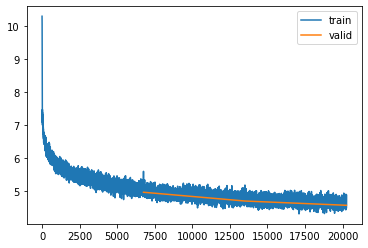

In [23]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train')
valid_x_axis = [(1 + k) * len(train_losses)/len(valid_losses)
                for k in range(len(valid_losses))]
plt.plot(valid_x_axis, valid_losses, label='valid')
plt.legend()

# Inference

We will now use our trained language model to actually generate text. Let's understand how that will happen. Remember from the beginning of the notebook that our LM actually is modeling the probability distribution of a token conditioned on the previous ones, right?: $p\left(y_t|  y_1, \ldots, y_{t-1} \right)$ . So at each time step, we have a categorical probability distribution (i.e. the probability for the next token to be each of the possible tokens in our vocabulary). How do we obtain a token from a probability distribution over the token space? There are many ways but the most straightforward ones are:

* Greedily: taking the most probable token (i.e. the token with highest probability, normally with `torch.argmax`).
* Sampling: drawing a random sample from the categorical distribution, normally done with `torch.multinomial`.

This way, we will predict the next token with one of the techniques above. Then, we will use this prediction as input for the next prediction, and so on. This is called "**auto-regressive**" inference.

Nevertheless, we will not start from scratch. Instead, we will give the LM a piece of text (the "context") to be used as starting point, and then the LM should generate the following text.

First of all, we need a function that performs over the same preprocessing over the context text that we performed for the training, validation and test data at the beginning of the notebook (normalization, tokenization and lowercasing), so that we can use it as input for our network:

In [0]:
from sacremoses import MosesTokenizer, MosesDetokenizer, MosesPunctNormalizer

normalizer = MosesPunctNormalizer()
tokenizer = MosesTokenizer(lang='en')

def text2token_ids(token2idx, unk_token_id, text):
    # TODO: implement the same preprocessing as with the
    #       train/valid/test datasets, using sacremoses programmatic API
    #       (normalization, tokenization, lowercasing). You can
    #       check how to use it at https://github.com/alvations/sacremoses/
    norm_text = normalizer.normalize(text.lower())
    tok_text = tokenizer.tokenize(norm_text)
    text_token_ids = [token2idx.get(token, unk_token_id) for token in tok_text]
    return text_token_ids

Now we are actually going to use the LM to generate text. 


For this, we will supply the context text to the language model. The output of the LSTM will be our first prediction. We will use it as the input for the next token prediction, and so on. We will also need to carry the hidden state generated from the previous prediction.

We will start by implementing greedy inference:

In [0]:
def inference_greedy(model, token2idx, idx2token, unk_token_id, eos_token_id, prefix_text, max_prediction_length):
    text_token_ids = text2token_ids(token2idx, unk_token_id, prefix_text)
    model.eval()
    with torch.no_grad():
        hidden = model.init_hidden(1)
        input = torch.LongTensor(text_token_ids).cuda().view(-1, 1)
        output, hidden = model(input, hidden)
        predicted_id = output.argmax()
        text_token_ids.append(predicted_id.item())
        prediction_len = 1
        while predicted_id != eos_token_id and prediction_len < max_prediction_length:
            input = torch.LongTensor(predicted_id).view(-1, 1)
            output, hidden = model(input, hidden)
            predicted_id = output.argmax()
            text_token_ids.append(predicted_id)
            prediction_len += 1

    return " ".join(idx2token[id] for id in text_token_ids)

Let's try it:

In [0]:
inference_greedy(model, token2idx, idx2token, unk_token_id, eos_token_id, "The Prime Minister declared", 20)

Now we will implement random sampling:

In [0]:
def inference_sampling(model, token2idx, idx2token, unk_token_id, eos_token_id, prefix_text, prediction_length):
    # TODO: implement inference with sampling from the
    #       categorical (multinomial) probability distribution.
    text_token_ids = text2token_ids(token2idx, unk_token_id, prefix_text)
    model.eval()
    with torch.no_grad():
        hidden = model.init_hidden(1)
        input = torch.LongTensor(text_token_ids).cuda().view(-1, 1)
        output, hidden = model(input, hidden)
        predicted_id = torch.multinomial(output, 1)
        text_token_ids.append(predicted_id.item())
        prediction_len = 1
        while predicted_id != eos_token_id and prediction_len < max_prediction_length:
            input = torch.LongTensor(predicted_id).view(-1, 1)
            output, hidden = model(input, hidden)
            predicted_id = torch.multinomial(output, 1)
            text_token_ids.append(predicted_id)
            prediction_len += 1

    return " ".join(idx2token[id] for id in text_token_ids)

Let's try it:

In [0]:
inference(model, random_sampling, token2idx, idx2token, unk_token_id, eos_token_id, "Hospitals in new york", 20)